In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import malaya_speech
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int
malaya_speech

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


<module 'malaya_speech' from '/home/ubuntu/.local/lib/python3.8/site-packages/malaya_speech/__init__.py'>

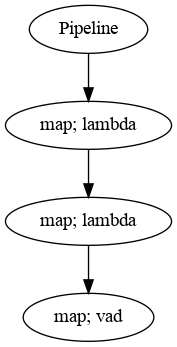

In [3]:
vad_model = malaya_speech.vad.webrtc()
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
    .map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

In [5]:
from glob import glob

youtubes = sorted(glob('HARRY*.mp3'))
youtubes

['HARRY POTTER DAN BILIK RAHSIA (BAB 1) ｜ MALAY AUDIOBOOK [1tnfiH-dLDI].mp3',
 'HARRY POTTER DAN BILIK RAHSIA (BAB 2) ｜ MALAY AUDIOBOOK [6PbzdKnLmZA].mp3',
 'HARRY POTTER DAN BILIK RAHSIA (BAB 3) - MALAY AUDIOBOOK [ikQilu3cYsY].mp3',
 'HARRY POTTER DAN BILIK RAHSIA (BAB 4) - MALAY AUDIOBOOK [SVeFRVjO_NM].mp3',
 'HARRY POTTER DAN BILIK RAHSIA (BAB 5) - MALAY AUDIOBOOK [VNaA5Ghb4FU].mp3',
 'HARRY POTTER DAN BILIK RAHSIA (BAB 6) ｜ MALAY AUDIOBOOK [rqBKOBiOqsM].mp3']

In [6]:
import whisper

model = whisper.load_model('large-v2')

In [7]:
from whisper.audio import (
    FRAMES_PER_SECOND,
    HOP_LENGTH,
    N_FRAMES,
    N_SAMPLES,
    SAMPLE_RATE,
    log_mel_spectrogram,
    pad_or_trim,
)

def detect_lang(x):
    mel = log_mel_spectrogram(y.astype('float32'), padding=N_SAMPLES)
    content_frames = mel.shape[-1] - N_FRAMES
    mel_segment = pad_or_trim(mel, N_FRAMES).to('cuda')
    _, probs = model.detect_language(mel_segment)
    return probs

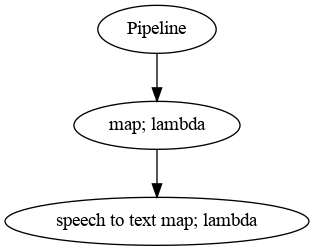

In [9]:
p_asr = Pipeline()
resample = p_asr.map(lambda x: malaya_speech.resample(x, old_samplerate = 22050, new_samplerate = 16000))
p = resample.map(lambda x: (
    detect_lang(x),
    model.transcribe(x.astype('float32'), task = 'transcribe', language = 'ms'),
    model.transcribe(x.astype('float32'), task = 'transcribe', language = 'en'),
), name = 'speech-to-text')
p_asr.visualize()

In [10]:
y = malaya_speech.load('/home/ubuntu/dev/malaya-speech/speech/example-speaker/husein-zolkepli.wav', sr = 22050)[0]

In [11]:
l = p_asr(y)['speech-to-text']

In [12]:
l

({'ba': 3.5424002620132455e-10,
  'as': 8.60829750308767e-05,
  'uk': 0.0001976128842215985,
  'lv': 1.2891571714135353e-05,
  'ro': 0.0006026251940056682,
  'kk': 1.390101169818081e-05,
  'bg': 5.460308966576122e-05,
  'mg': 3.358311744250386e-07,
  'bo': 0.00010008537356043234,
  'ca': 1.7723621112963883e-06,
  'sa': 6.63459868519567e-05,
  'id': 0.0038747312501072884,
  'fi': 2.327006950508803e-05,
  'sk': 1.8327989437239012e-06,
  'fr': 0.0016085506649687886,
  'bn': 5.781680374639109e-05,
  'kn': 2.8534479497466236e-05,
  'yi': 5.955907454335829e-06,
  'tr': 0.0009716611821204424,
  'sd': 0.00011648624786175787,
  'tg': 9.537285222904757e-06,
  'fo': 4.861907291342504e-05,
  'tk': 1.980550168312334e-09,
  'lb': 5.4341294344339985e-06,
  'my': 0.00022875821741763502,
  'no': 1.513301413069712e-05,
  'cs': 8.452375186607242e-05,
  'ml': 2.627744288474787e-05,
  'hy': 3.8739257433917373e-05,
  'is': 1.9145134046993917e-06,
  'ha': 3.481630847090855e-05,
  'te': 2.032508564298041e-05,

In [13]:
from unidecode import unidecode
import torchaudio
import torch
import pickle

In [14]:
parent_dir = 'processed-harry-potter'
# !rm -rf {parent_dir}
!mkdir {parent_dir}

In [15]:
parent_dir_done = 'processed-harry-potter-done'
# !rm -rf {parent_dir_done}
!mkdir {parent_dir_done}

In [16]:
from tqdm import tqdm
import random

In [17]:
for f in tqdm(youtubes):
    
    new_f = unidecode(os.path.split(f)[1].replace('.mp3', '').replace(' ', '_'))
    new_f = new_f.replace('/', '_')
    f_done = os.path.join(parent_dir_done, new_f)
    
    if os.path.exists(f_done):
        continue
    
    samples = malaya_speech.streaming.torchaudio.stream(f, mode_utterence = False,
                                                        vad_model = p_vad,
                                                        asr_model = p_asr,
                                                        segment_length = 441,
                                                        realtime_print = False,
                                                        sample_rate = 22050,
                                                        min_length = 10.0,
                                                        max_length = 10.0
                                                       )
    
    if len(samples):
        
        parent_new_f = os.path.join(parent_dir, new_f)
        os.makedirs(parent_new_f, exist_ok=True)

        for i in range(len(samples)):
            audio_path = os.path.join(parent_new_f, f'{i}.mp3')
            torchaudio.save(audio_path, 
                            torch.tensor(samples[i]['wav_data'].astype('float32')).unsqueeze(0), 
                            22050, format='mp3')
            samples[i]['wav_data'] = audio_path

        with open(f'{parent_new_f}.pkl', 'wb') as fopen:
            pickle.dump(samples, fopen)
            
    with open(f_done, 'w') as fopen:
        fopen.write('done')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [59:17<00:00, 592.88s/it]


In [26]:
max(samples[2]['asr_model'][0], key=samples[2]['asr_model'][0].get)

'ms'

In [29]:
import numpy as np

ms_score = [s['avg_logprob'] for s in samples[2]['asr_model'][1]['segments']]
en_score = [s['avg_logprob'] for s in samples[2]['asr_model'][2]['segments']]

if np.mean(ms_score) > np.mean(en_score):
    selected = samples[2]['asr_model'][1]['segments']
else:
    selected = samples[2]['asr_model'][2]['segments']
    
selected

[{'id': 0,
  'seek': 0,
  'start': 0.0,
  'end': 2.56,
  'text': ' Harry tidak mampu tersenyum lagi.',
  'tokens': [50364,
   9378,
   18943,
   275,
   1215,
   84,
   256,
   433,
   43100,
   449,
   17742,
   13,
   50492],
  'temperature': 0.0,
  'avg_logprob': -0.296196044437469,
  'compression_ratio': 1.3770491803278688,
  'no_speech_prob': 0.019584331661462784},
 {'id': 1,
  'seek': 0,
  'start': 2.56,
  'end': 7.08,
  'text': ' Keadaan bertambah buruk sejak waktu sarapan di dewan besar.',
  'tokens': [50492,
   3189,
   1538,
   282,
   50098,
   2173,
   545,
   2779,
   2034,
   369,
   36230,
   44782,
   13782,
   3140,
   1026,
   368,
   7916,
   48327,
   13,
   50718],
  'temperature': 0.0,
  'avg_logprob': -0.296196044437469,
  'compression_ratio': 1.3770491803278688,
  'no_speech_prob': 0.019584331661462784},
 {'id': 2,
  'seek': 0,
  'start': 7.08,
  'end': 13.08,
  'text': ' Empat buah meja panjang di dewan itu dipenuhi diretan mangkuk turin bubur.',
  'tokens': [5